# Latent Dirichlet Allocation 

Latent Dirichlet Allocation (LDA) is a generative probabilistic model for natural texts. It is used in problems such as automated topic discovery, collaborative filtering, and document classification.

In addition to an implementation of LDA, this MADlib module also provides a number of additional helper functions to interpret results of the LDA output.

In [1]:
%load_ext sql

/Users/fmcquillan/anaconda/lib/python2.7/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated since IPython 4.0. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/Users/fmcquillan/anaconda/lib/python2.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


In [2]:
# Greenplum Database 5.x on GCP (PM demo machine) - direct external IP access
#%sql postgresql://gpadmin@34.67.65.96:5432/madlib

# Greenplum Database 5.x on GCP - via tunnel
%sql postgresql://gpadmin@localhost:8000/madlib
        
# PostgreSQL local
#%sql postgresql://fmcquillan@localhost:5432/madlib

u'Connected: gpadmin@madlib'

In [3]:
%sql select madlib.version();
#%sql select version();

1 rows affected.


version
"MADlib version: 1.17-dev, git revision: rel/v1.16-40-gfc8af4e, cmake configuration time: Thu Nov 7 22:54:15 UTC 2019, build type: release, build system: Linux-3.10.0-957.27.2.el7.x86_64, C compiler: gcc 4.8.5, C++ compiler: g++ 4.8.5"


# 1.  Prepare documents
The examples below are short strings extracted from various Wikipedia documents. First we create a document table with one document per row:

In [4]:
%%sql
DROP TABLE IF EXISTS documents;
CREATE TABLE documents(docid INT4, contents TEXT);

INSERT INTO documents VALUES
(0, 'Statistical topic models are a class of Bayesian latent variable models, originally developed for analyzing the semantic content of large document corpora.'),
(1, 'By the late 1960s, the balance between pitching and hitting had swung in favor of the pitchers. In 1968 Carl Yastrzemski won the American League batting title with an average of just .301, the lowest in history.'),
(2, 'Machine learning is closely related to and often overlaps with computational statistics; a discipline that also specializes in prediction-making. It has strong ties to mathematical optimization, which deliver methods, theory and application domains to the field.'),
(3, 'California''s diverse geography ranges from the Sierra Nevada in the east to the Pacific Coast in the west, from the Redwood–Douglas fir forests of the northwest, to the Mojave Desert areas in the southeast. The center of the state is dominated by the Central Valley, a major agricultural area.');

SELECT * from documents ORDER BY docid;

Done.
Done.
4 rows affected.
4 rows affected.


docid,contents
0,"Statistical topic models are a class of Bayesian latent variable models, originally developed for analyzing the semantic content of large document corpora."
1,"By the late 1960s, the balance between pitching and hitting had swung in favor of the pitchers. In 1968 Carl Yastrzemski won the American League batting title with an average of just .301, the lowest in history."
2,"Machine learning is closely related to and often overlaps with computational statistics; a discipline that also specializes in prediction-making. It has strong ties to mathematical optimization, which deliver methods, theory and application domains to the field."
3,"California's diverse geography ranges from the Sierra Nevada in the east to the Pacific Coast in the west, from the Redwood–Douglas fir forests of the northwest, to the Mojave Desert areas in the southeast. The center of the state is dominated by the Central Valley, a major agricultural area."


You can apply stemming, stop word removal and tokenization at this point in order to prepare the documents for text processing.  Depending upon your database version, various tools are available.  Databases based on more recent versions of PostgreSQL may do something like: 

In [ ]:
%%sql
SELECT tsvector_to_array(to_tsvector('english',contents)) from documents;

In this example, we assume a database based on an older version of PostgreSQL and just perform basic punctuation removal and tokenization. The array of words is added as a new column to the documents table:

In [5]:
%%sql
ALTER TABLE documents ADD COLUMN words TEXT[];

UPDATE documents SET words = 
    regexp_split_to_array(lower(
    regexp_replace(contents, E'[,.;\']','', 'g')
    ), E'[\\s+]');
    
SELECT * FROM documents ORDER BY docid;

Done.
4 rows affected.
4 rows affected.


docid,contents,words
0,"Statistical topic models are a class of Bayesian latent variable models, originally developed for analyzing the semantic content of large document corpora.","[u'statistical', u'topic', u'models', u'are', u'a', u'class', u'of', u'bayesian', u'latent', u'variable', u'models', u'originally', u'developed', u'for', u'analyzing', u'the', u'semantic', u'content', u'of', u'large', u'document', u'corpora']"
1,"By the late 1960s, the balance between pitching and hitting had swung in favor of the pitchers. In 1968 Carl Yastrzemski won the American League batting title with an average of just .301, the lowest in history.","[u'by', u'the', u'late', u'1960s', u'the', u'balance', u'between', u'pitching', u'and', u'hitting', u'had', u'swung', u'in', u'favor', u'of', u'the', u'pitchers', u'in', u'1968', u'carl', u'yastrzemski', u'won', u'the', u'american', u'league', u'batting', u'title', u'with', u'an', u'average', u'of', u'just', u'301', u'the', u'lowest', u'in', u'history']"
2,"Machine learning is closely related to and often overlaps with computational statistics; a discipline that also specializes in prediction-making. It has strong ties to mathematical optimization, which deliver methods, theory and application domains to the field.","[u'machine', u'learning', u'is', u'closely', u'related', u'to', u'and', u'often', u'overlaps', u'with', u'computational', u'statistics', u'a', u'discipline', u'that', u'also', u'specializes', u'in', u'prediction-making', u'it', u'has', u'strong', u'ties', u'to', u'mathematical', u'optimization', u'which', u'deliver', u'methods', u'theory', u'and', u'application', u'domains', u'to', u'the', u'field']"
3,"California's diverse geography ranges from the Sierra Nevada in the east to the Pacific Coast in the west, from the Redwood–Douglas fir forests of the northwest, to the Mojave Desert areas in the southeast. The center of the state is dominated by the Central Valley, a major agricultural area.","[u'californias', u'diverse', u'geography', u'ranges', u'from', u'the', u'sierra', u'nevada', u'in', u'the', u'east', u'to', u'the', u'pacific', u'coast', u'in', u'the', u'west', u'from', u'the', u'redwood\u2013douglas', u'fir', u'forests', u'of', u'the', u'northwest', u'to', u'the', u'mojave', u'desert', u'areas', u'in', u'the', u'southeast', u'the', u'center', u'of', u'the', u'state', u'is', u'dominated', u'by', u'the', u'central', u'valley', u'a', u'major', u'agricultural', u'area']"


# 2.  Term frequency
Build a word count table by extracting the words and building a histogram for each document using the term_frequency() function.

In [6]:
%%sql
DROP TABLE IF EXISTS documents_tf, documents_tf_vocabulary;

SELECT madlib.term_frequency('documents',    -- input table
                             'docid',        -- document id column
                             'words',        -- vector of words in document
                             'documents_tf', -- output documents table with term frequency
                             TRUE);          -- TRUE to created vocabulary table

SELECT * FROM documents_tf ORDER BY docid LIMIT 20;

Done.
1 rows affected.
20 rows affected.


docid,wordid,count
0,17,1
0,11,1
0,95,1
0,90,1
0,85,1
0,68,2
0,54,1
0,42,1
0,35,1
0,28,1


Here is the associated vocabulary table.  Note that wordid starts at 0:

In [7]:
%%sql
SELECT * FROM documents_tf_vocabulary ORDER BY wordid LIMIT 20;

20 rows affected.


wordid,word
0,1960s
1,1968
2,301
3,a
4,agricultural
5,also
6,american
7,an
8,analyzing
9,and


The total number of words in the vocabulary across all documents is:

In [8]:
%%sql
SELECT COUNT(*) FROM documents_tf_vocabulary;

1 rows affected.


count
103


# 3. Train LDA model
For Dirichlet priors we use initial rule-of-thumb values of 50/(number of topics) for alpha and 0.01 for beta.

Reminder that column names for docid, wordid, and count are currently fixed, so you must use these exact names in the input table. After a successful run of the LDA training function two tables are generated, one for storing the learned model and the other for storing the output data table.

In [9]:
%%sql
DROP TABLE IF EXISTS lda_model, lda_output_data;

SELECT madlib.lda_train( 'documents_tf',     -- documents table in the form of term frequency
                         'lda_model',        -- model table created by LDA training (not human readable)
                         'lda_output_data',  -- readable output data table 
                         103,                -- vocabulary size
                         5,                  -- number of topics
                         10,                 -- number of iterations
                         5,                  -- Dirichlet prior for the per-doc topic multinomial (alpha)
                         0.01                -- Dirichlet prior for the per-topic word multinomial (beta)
                       );

SELECT * FROM lda_output_data ORDER BY docid;

Done.
2 rows affected.
4 rows affected.


docid,wordcount,words,counts,topic_count,topic_assignment
0,22,"[24, 17, 11, 95, 90, 85, 68, 54, 42, 35, 28, 8, 3, 97, 80, 71, 64, 56, 32, 29]","[1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1]","[3, 5, 8, 5, 1]","[3, 2, 1, 3, 0, 0, 3, 3, 1, 2, 1, 4, 2, 0, 1, 2, 2, 2, 2, 1, 2, 3]"
1,37,"[1, 50, 49, 46, 19, 16, 14, 9, 7, 0, 90, 68, 57, 102, 101, 100, 93, 88, 75, 74, 59, 55, 53, 48, 39, 21, 18, 15, 6, 2]","[1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 5, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[11, 7, 2, 11, 6]","[0, 0, 0, 0, 1, 3, 2, 1, 1, 1, 3, 1, 0, 0, 0, 4, 4, 3, 3, 4, 4, 2, 3, 3, 1, 1, 3, 3, 3, 3, 0, 4, 3, 0, 4, 0, 0]"
2,36,"[10, 27, 33, 40, 47, 51, 58, 62, 63, 69, 72, 83, 100, 99, 94, 92, 91, 90, 89, 87, 86, 79, 76, 70, 60, 52, 50, 36, 30, 25, 9, 5, 3]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1]","[9, 12, 5, 5, 5]","[0, 0, 1, 4, 3, 4, 3, 3, 2, 2, 3, 2, 0, 1, 0, 0, 0, 2, 1, 4, 1, 1, 1, 4, 4, 2, 1, 3, 0, 1, 1, 1, 1, 1, 0, 0]"
3,49,"[77, 78, 81, 82, 67, 65, 51, 45, 44, 43, 34, 26, 13, 98, 96, 94, 90, 84, 73, 68, 66, 61, 50, 41, 38, 37, 31, 23, 22, 20, 19, 12, 4, 3]","[1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 11, 1, 1, 2, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[12, 4, 11, 3, 19]","[2, 1, 3, 4, 1, 4, 0, 0, 4, 4, 4, 2, 1, 4, 2, 4, 0, 1, 4, 4, 0, 0, 4, 4, 4, 4, 0, 4, 4, 4, 4, 3, 3, 2, 2, 0, 0, 0, 2, 0, 2, 2, 0, 2, 4, 2, 2, 4, 0]"


In [10]:
%%sql
SELECT voc_size, topic_num, alpha, beta, num_iterations, perplexity, perplexity_iters from lda_model;

1 rows affected.


voc_size,topic_num,alpha,beta,num_iterations,perplexity,perplexity_iters
103,5,5.0,0.01,10,None,None


# 4. Helper functions on learned model  

First, we get topic description by top-k words.  These are the k words with the highest probability for the topic.

Note that if there are ties in probability, more than k words may actually be reported for each topic.  Also note that topicid starts at 0.

In [11]:
%%sql
DROP TABLE IF EXISTS helper_output_table;

SELECT madlib.lda_get_topic_desc( 'lda_model',                -- LDA model generated in training
                                  'documents_tf_vocabulary',  -- vocabulary table that maps wordid to word
                                  'helper_output_table',      -- output table for per-topic descriptions
                                  5);                         -- k: number of top words for each topic

SELECT * FROM helper_output_table ORDER BY topicid, prob DESC LIMIT 40;

Done.
1 rows affected.
40 rows affected.


topicid,wordid,prob,word
0,50,0.194560088815,in
0,90,0.194560088815,the
0,94,0.111296142104,to
0,3,0.0835414932001,a
0,85,0.0280321953927,statistical
0,5,0.0280321953927,also
0,1,0.0280321953927,1968
0,18,0.0280321953927,between
0,2,0.0280321953927,301
0,38,0.0280321953927,east


Get the per-word topic counts.  This mapping shows how many times a given word is assigned to a topic.  E.g., wordid 3 is assigned to topicid 0 three times. 

In [12]:
%%sql
DROP TABLE IF EXISTS helper_output_table;

SELECT madlib.lda_get_word_topic_count( 'lda_model',            -- LDA model generated in training
                                        'helper_output_table'); -- output table for per-word topic counts

SELECT * FROM helper_output_table ORDER BY wordid LIMIT 20;

Done.
1 rows affected.
20 rows affected.


wordid,topic_count
0,"[0, 1, 0, 0, 0]"
1,"[1, 0, 0, 0, 0]"
2,"[1, 0, 0, 0, 0]"
3,"[3, 0, 0, 0, 0]"
4,"[0, 0, 0, 0, 1]"
5,"[1, 0, 0, 0, 0]"
6,"[1, 0, 0, 0, 0]"
7,"[0, 0, 0, 1, 0]"
8,"[0, 0, 1, 0, 0]"
9,"[0, 3, 0, 0, 0]"


Get the per-topic word counts.   This mapping shows which words are associated with each topic by frequency.

In [13]:
%%sql
DROP TABLE IF EXISTS helper_output_table;

SELECT madlib.lda_get_topic_word_count( 'lda_model',
                                        'helper_output_table');

SELECT * FROM helper_output_table ORDER BY topicid;

Done.
1 rows affected.
5 rows affected.


topicid,word_count
0,"[0, 1, 1, 3, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 7, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 7, 0, 0, 0, 4, 0, 0, 0, 0, 0, 1, 0, 0]"
1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0]"
2,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 2, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0]"
3,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 6, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0]"
4,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 11, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1]"


Get the per-document word to topic mapping:

In [14]:
%%sql
DROP TABLE IF EXISTS helper_output_table;

SELECT madlib.lda_get_word_topic_mapping('lda_output_data',
                                         'helper_output_table');

SELECT * FROM helper_output_table ORDER BY docid LIMIT 40;

Done.
1 rows affected.
40 rows affected.


docid,wordid,topicid
0,56,1
0,54,1
0,42,2
0,35,1
0,32,2
0,29,3
0,28,4
0,24,3
0,17,2
0,11,1


# 6. Predict
Use a learned LDA model for prediction (that is, to label new documents).  In this example, we use the same input table as we used to train, just for demonstration purpose.  Normally, the test document is a new one that we want to predict on.

In [15]:
%%sql
DROP TABLE IF EXISTS outdata_predict;

SELECT madlib.lda_predict( 'documents_tf',          -- Document to predict
                           'lda_model',             -- LDA model from training
                           'outdata_predict'                
                         );

SELECT * FROM outdata_predict ORDER BY docid;

Done.
1 rows affected.
4 rows affected.


docid,wordcount,words,counts,topic_count,topic_assignment
0,22,"[24, 17, 11, 95, 90, 85, 68, 54, 42, 35, 28, 8, 3, 97, 80, 71, 64, 56, 32, 29]","[1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1]","[0, 0, 1, 19, 2]","[3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 2, 3, 3, 3, 3]"
1,37,"[1, 50, 49, 46, 19, 16, 14, 9, 7, 0, 90, 68, 57, 102, 101, 100, 93, 88, 75, 74, 59, 55, 53, 48, 39, 21, 18, 15, 6, 2]","[1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 5, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[9, 1, 3, 3, 21]","[4, 0, 0, 0, 4, 4, 2, 0, 0, 1, 4, 4, 4, 4, 0, 4, 4, 3, 3, 2, 4, 4, 4, 0, 0, 0, 4, 4, 4, 4, 4, 3, 4, 4, 2, 4, 4]"
2,36,"[10, 27, 33, 40, 47, 51, 58, 62, 63, 69, 72, 83, 100, 99, 94, 92, 91, 90, 89, 87, 86, 79, 76, 70, 60, 52, 50, 36, 30, 25, 9, 5, 3]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1]","[9, 5, 0, 20, 2]","[3, 3, 3, 3, 3, 4, 0, 3, 3, 0, 3, 3, 0, 3, 1, 0, 0, 0, 3, 4, 3, 3, 3, 1, 1, 0, 3, 3, 0, 3, 3, 3, 1, 1, 3, 0]"
3,49,"[77, 78, 81, 82, 67, 65, 51, 45, 44, 43, 34, 26, 13, 98, 96, 94, 90, 84, 73, 68, 66, 61, 50, 41, 38, 37, 31, 23, 22, 20, 19, 12, 4, 3]","[1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 11, 1, 1, 2, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[17, 1, 1, 8, 22]","[3, 0, 4, 4, 3, 0, 4, 4, 4, 3, 4, 4, 4, 4, 0, 2, 1, 0, 0, 0, 4, 4, 0, 0, 0, 4, 4, 4, 4, 0, 4, 3, 3, 4, 3, 0, 0, 0, 3, 4, 4, 3, 4, 0, 4, 0, 0, 4, 0]"


# 7. Helper function on prediction

In [16]:
%%sql
DROP TABLE IF EXISTS helper_output_table;

SELECT madlib.lda_get_word_topic_mapping('outdata_predict',  -- Output table from prediction
                                         'helper_output_table');

SELECT * FROM helper_output_table ORDER BY docid LIMIT 40;

Done.
1 rows affected.
40 rows affected.


docid,wordid,topicid
0,56,3
0,54,3
0,42,3
0,35,3
0,32,3
0,29,3
0,28,3
0,24,3
0,17,3
0,11,3


# 8. Perplexity on final model

Call perplexity function to see how well the model fits the data.  Perplexity computes word likelihoods averaged over the test documents.

In [17]:
%%sql
SELECT madlib.lda_get_perplexity( 'lda_model',
                                  'outdata_predict'
                                );

1 rows affected.


lda_get_perplexity
77.1798997241


# 9. Perplexity by iteration
Now let's look at how perplexity changes from one iteration to the next:

In [18]:
%%sql
DROP TABLE IF EXISTS lda_model_perp, lda_output_data_perp;

SELECT madlib.lda_train( 'documents_tf',          -- documents table in the form of term frequency
                         'lda_model_perp',        -- model table created by LDA training (not human readable)
                         'lda_output_data_perp',  -- readable output data table 
                         103,                     -- vocabulary size
                         5,                       -- number of topics
                         30,                      -- number of iterations
                         5,                       -- Dirichlet prior for the per-doc topic multinomial (alpha)
                         0.01,                    -- Dirichlet prior for the per-topic word multinomial (beta)
                         2,                       -- Evaluate perplexity every n iterations
                         0.3                      -- Tolerance to stop iteration
                       );

SELECT * FROM lda_output_data_perp ORDER BY docid;

Done.
2 rows affected.
4 rows affected.


docid,wordcount,words,counts,topic_count,topic_assignment
0,22,"[24, 17, 11, 95, 90, 85, 68, 54, 42, 35, 28, 8, 3, 97, 80, 71, 64, 56, 32, 29]","[1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1]","[5, 0, 6, 3, 8]","[2, 4, 0, 4, 3, 0, 2, 2, 0, 2, 0, 3, 4, 4, 0, 2, 4, 4, 4, 4, 3, 2]"
1,37,"[1, 50, 49, 46, 19, 16, 14, 9, 7, 0, 90, 68, 57, 102, 101, 100, 93, 88, 75, 74, 59, 55, 53, 48, 39, 21, 18, 15, 6, 2]","[1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 5, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[4, 10, 8, 8, 7]","[4, 0, 0, 0, 0, 3, 1, 4, 1, 1, 3, 4, 2, 3, 3, 2, 2, 2, 2, 1, 4, 1, 1, 2, 3, 2, 1, 1, 2, 1, 4, 1, 3, 4, 3, 4, 3]"
2,36,"[10, 27, 33, 40, 47, 51, 58, 62, 63, 69, 72, 83, 100, 99, 94, 92, 91, 90, 89, 87, 86, 79, 76, 70, 60, 52, 50, 36, 30, 25, 9, 5, 3]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1]","[3, 6, 12, 4, 11]","[2, 4, 3, 4, 3, 4, 2, 1, 3, 2, 4, 4, 1, 4, 2, 2, 2, 2, 4, 2, 1, 2, 3, 1, 2, 4, 0, 4, 0, 2, 4, 0, 1, 1, 2, 4]"
3,49,"[77, 78, 81, 82, 67, 65, 51, 45, 44, 43, 34, 26, 13, 98, 96, 94, 90, 84, 73, 68, 66, 61, 50, 41, 38, 37, 31, 23, 22, 20, 19, 12, 4, 3]","[1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 11, 1, 1, 2, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[12, 6, 12, 16, 3]","[1, 2, 1, 0, 2, 0, 3, 2, 0, 0, 1, 2, 3, 3, 3, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 0, 0, 2, 2, 3, 4, 0, 0, 0, 1, 4, 2, 1, 2, 3, 0, 1, 0, 0, 4]"


In [19]:
%%sql
SELECT voc_size, topic_num, alpha, beta, num_iterations, perplexity, perplexity_iters from lda_model_perp;

1 rows affected.


voc_size,topic_num,alpha,beta,num_iterations,perplexity,perplexity_iters
103,5,5.0,0.01,10,"[67.1591056287, 69.9501444785, 66.7049790698, 68.0639898651, 68.2407536396]","[2, 4, 6, 8, 10]"


Double check that the perplexity is that same as the final value of the iteration:

In [20]:
%%sql
SELECT madlib.lda_get_perplexity( 'lda_model_perp',
                                  'lda_output_data_perp'
                                );

1 rows affected.


lda_get_perplexity
68.2407536396


Plot perplexity by number of iterations

1 rows affected.
1 rows affected.
1 rows affected.


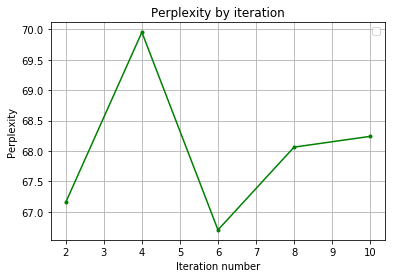

In [22]:
import pandas as pd
import numpy as np
import sys
import os
from matplotlib import pyplot as plt

# get accuracy and iteration number
iters_proxy = %sql SELECT perplexity_iters FROM lda_model_perp;
perplexity_proxy = %sql SELECT perplexity FROM lda_model_perp;

# get number of points
num_points_proxy = %sql SELECT array_length(perplexity_iters,1) FROM lda_model_perp;
num_points = num_points_proxy[0]

# reshape to np arrays
iters = np.array(iters_proxy).reshape(num_points)
perplexity = np.array(perplexity_proxy).reshape(num_points)

#plot
plt.title('Perplexity by iteration')
plt.xlabel('Iteration number')
plt.ylabel('Perplexity')
plt.grid(True)
plt.plot(iters, perplexity, 'g.-')
plt.legend()